# Prosper Loan Data Exploration
## By Yaqoob David

## Investigation Overview

In this investigation I wanted to figure out two things:

* The factors which can be used to predict default on credit.
* What factors influence Prosper rating.

## Dataset Overview

This data set contains 113937 loans with 81 variables on each loan, for the purpose of this investigation I've taken the following variables: Term, LoanStatus, BorrowerRate, ProsperRating (Alpha), ListingCategory (numeric), EmploymentStatus, DelinquenciesLast7Years, StatedMonthlyIncome, TotalProsperLoans, LoanOriginalAmount, LoanOriginationDate, Recommendations, Investors.

In [1]:
# import all packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter("ignore")

%matplotlib inline

In [2]:
df = pd.read_csv('prosperLoanData.csv')

In [3]:
df.head()

,ListingKey,ListingNumber,ListingCreationDate,CreditGrade,Term,LoanStatus,ClosedDate,BorrowerAPR,BorrowerRate,LenderYield,...,LP_ServiceFees,LP_CollectionFees,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors
0,1021339766868145413AB3B,193129,2007-08-26 19:09:29.263000000,C,36,Completed,2009-08-14 00:00:00,0.16516,0.1580,0.1380,...,-133.18,0.0,0.0,0.0,0.0,1.0,0,0,0.0,258
1,10273602499503308B223C1,1209647,2014-02-27 08:28:07.900000000,NaN,36,Current,NaN,0.12016,0.0920,0.0820,...,0.00,0.0,0.0,0.0,0.0,1.0,0,0,0.0,1
2,0EE9337825851032864889A,81716,2007-01-05 15:00:47.090000000,HR,36,Completed,2009-12-17 00:00:00,0.28269,0.2750,0.2400,...,-24.20,0.0,0.0,0.0,0.0,1.0,0,0,0.0,41
3,0EF5356002482715299901A,658116,2012-10-22 11:02:35.010000000,NaN,36,Current,NaN,0.12528,0.0974,0.0874,...,-108.01,0.0,0.0,0.0,0.0,1.0,0,0,0.0,158
4,0F023589499656230C5E3E2,909464,2013-09-14 18:38:39.097000000,NaN,36,Current,NaN,0.24614,0.2085,0.1985,...,-60.27,0.0,0.0,0.0,0.0,1.0,0,0,0.0,20


In [4]:
base_color = sns.color_palette()[0] #for color

## Wrangling

In [5]:
target_columns =  [
    'Term', 'LoanStatus', 'BorrowerRate', 'ProsperRating (Alpha)', 'ListingCategory (numeric)', 'EmploymentStatus',
    'DelinquenciesLast7Years', 'StatedMonthlyIncome', 'TotalProsperLoans', 'LoanOriginalAmount',
    'LoanOriginationDate', 'Recommendations', 'Investors'
]
target_df = df[target_columns]
target_df = target_df.dropna(subset=['ProsperRating (Alpha)']).reset_index()
target_df['LoanOriginationDate'] = pd.to_datetime(target_df['LoanOriginationDate'])
target_df['TotalProsperLoans'] = target_df['TotalProsperLoans'].fillna(0)

## Loan status

**Observation 1:** 
* Most of the loans in the data set are actually current loans. 
* Past due loans are split in several groups based on the length of payment delay.
* Other big part is completed loans, defaulted loans compromise a minority, however chargedoff loans also comporomise a substanial amount.

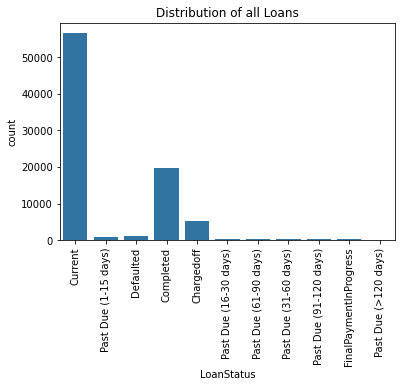

In [6]:
# setting color
base_color = sns.color_palette()[0]
plt.xticks(rotation=90)
sns.countplot(data = target_df, x = 'LoanStatus', color = base_color);
plt.title("Distribution of all Loans");

## Employment Status

**Observation 2:** 
* The majority of borrowers are employed and all other categories as small part of borrowers. 
* In small Group full time has highest, after that self empolyed are there and so on.

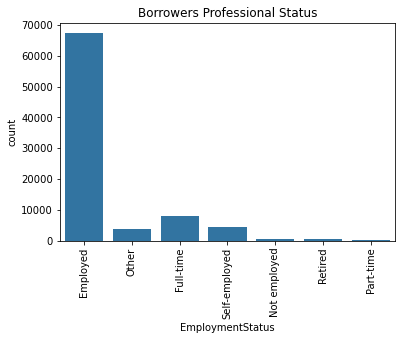

In [7]:
sns.countplot(data = target_df, x = 'EmploymentStatus', color = base_color);
plt.xticks(rotation = 90)
plt.title("Borrowers Professional Status");

## Stated Monthly Income
**Observation 3:**
* With a boundary of mean and 3 times standard deviations distribution of monthly income still has noticeable right skew but now we can see that mode is about 5000.  

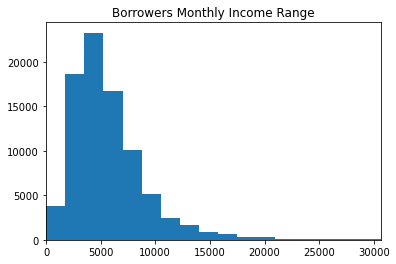

In [8]:
income_std = target_df['StatedMonthlyIncome'].std()
income_mean = target_df['StatedMonthlyIncome'].mean()
boundary = income_mean + income_std * 3
#len(target_df[target_df['StatedMonthlyIncome'] >= boundary])
plt.hist(data=target_df, x='StatedMonthlyIncome', bins=1000);
plt.xlim(0, boundary)
plt.title("Borrowers Monthly Income Range");

In [9]:
condition = (target_df['LoanStatus'] == 'Completed') | (target_df['LoanStatus'] == 'Defaulted') |\
                  (target_df['LoanStatus'] == 'Chargedoff')
target_df = target_df[condition]

def change_to_defaulted(row):
    """ Function to find defaulted"""
    if row['LoanStatus'] == 'Chargedoff':
        return 'Defaulted'
    else:
        return row['LoanStatus']
    
target_df['LoanStatus'] = target_df.apply(change_to_defaulted, axis=1)
categories = {1: 'Debt Consolidation', 2: 'Home Improvement', 3: 'Business', 6: 'Auto', 7: 'Other'}

def reduce_categorie(row):
    """ Function reduce categorie"""
    loan_category = row['ListingCategory (numeric)']
    if  loan_category in categories:
        return categories[loan_category]
    else:
        return categories[7]
    
target_df['ListingCategory (numeric)'] = target_df.apply(reduce_categorie, axis=1)

## Status and Prosper Rating:
**Observation 1:**
* The `most frequent` rating among defaulted loans is actually `D`.
* And the `most frequent` rating among Completed is also` D `and second highest is A and so on.

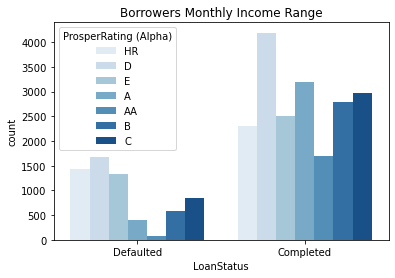

In [10]:
sns.countplot(data = target_df, x = 'LoanStatus', hue = 'ProsperRating (Alpha)', palette = 'Blues')
plt.title("Borrowers Monthly Income Range");

## Credit Start with Listing Category:
**Observation 2:**
* In both of the Graphs the `debt Consolidation` have `most frequency among all of them`.

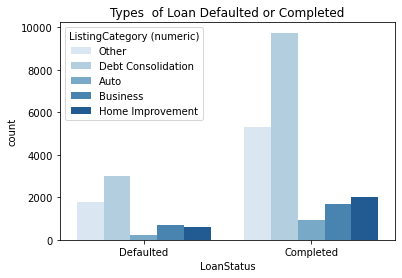

In [11]:
sns.countplot(data = target_df, x = 'LoanStatus', hue = 'ListingCategory (numeric)', palette = 'Blues')
plt.title("Types  of Loan Defaulted or Completed");

## Loan Status and Loan Amount
**Observation 3:**
* As from below Graph we can state that `defaulted credits` tend to be `smaller` than `completed credits` onces. 

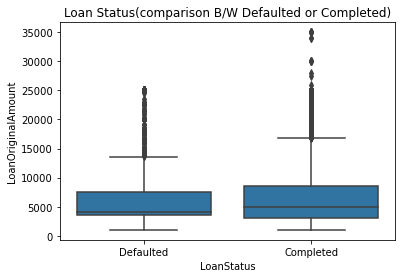

In [12]:
sns.boxplot(data = target_df, x = 'LoanStatus', y = 'LoanOriginalAmount', color = base_color)
plt.title("Loan Status(comparison B/W Defaulted or Completed)");

## Prosper Rating and Employment Status
**Observation 4:**
* Lower ratings seem to have greater proportions of individuals with employment status Not Employed, Self-employed, Retired and Part-Time.

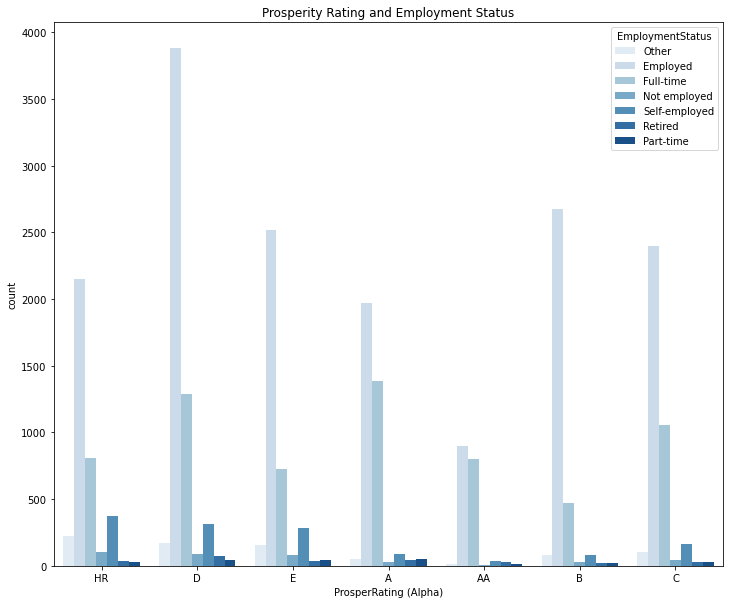

In [13]:
plt.figure(figsize = [12, 10])
sns.countplot(data = target_df, x = 'ProsperRating (Alpha)', hue = 'EmploymentStatus', palette = 'Blues')
plt.title("Prosperity Rating and Employment Status");

## Rating, Loan Amount and Loan Status
**Observation 1:**
* Except for the lowest ratings defaulted credits tend to be larger than completed.
* Most of the defaulted credits comes from individuals with low Prosper rating.

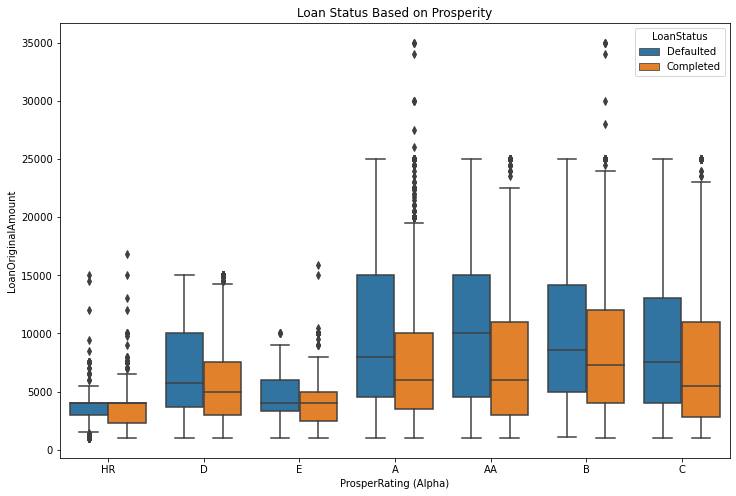

In [14]:
plt.figure(figsize = [12, 8])
sns.boxplot(data=target_df, x='ProsperRating (Alpha)', y='LoanOriginalAmount', hue='LoanStatus')
plt.title("Loan Status Based on Prosperity");

## Relationships between Credit category, Credit rating and outcome of Credit.
**Observation 2:**
* There are 5 graphs in the second one has much up and downs in it other than all of them.
* There is no substantial difference for default rates in different categories broken up by ratings.

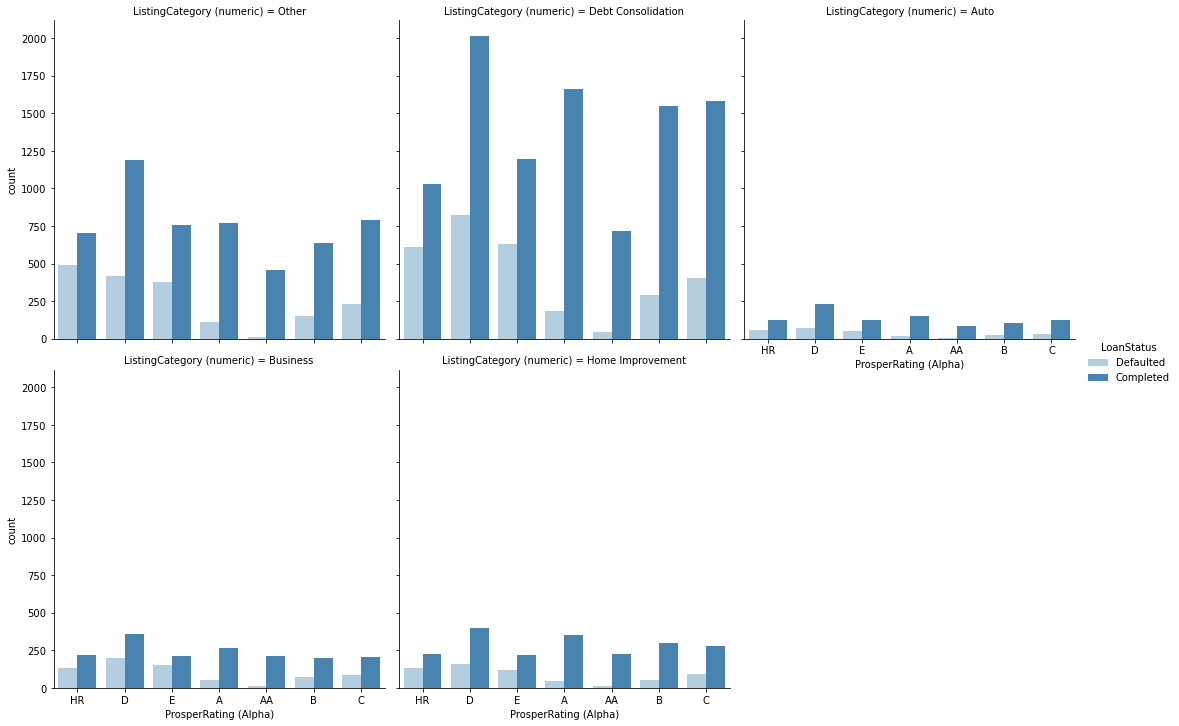

In [15]:
sns.catplot(x = 'ProsperRating (Alpha)', hue = 'LoanStatus', col = 'ListingCategory (numeric)',
              data = target_df, kind = 'count', palette = 'Blues', col_wrap = 3);

## Amount, Listing Category Loan and Loan Status Interact
**Observation 3:**
*  Except for Auto, Business and Home Improvemrnt dont have nearly equal mean amoong all of them.
*  Business category tend to have larger amount.

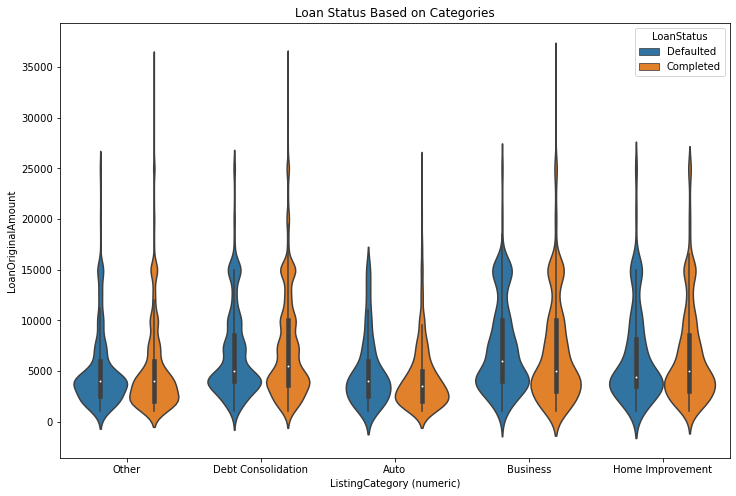

In [16]:
plt.figure(figsize = [12, 8])
sns.violinplot(data=target_df, x='ListingCategory (numeric)', y='LoanOriginalAmount', hue='LoanStatus')
plt.title("Loan Status Based on Categories");

In [17]:
!jupyter nbconvert Slides-Communicate-Data-Findings-master.ipynb --to slides --post serve --no-input --no-prompt

[NbConvertApp] WARNING | pattern 'Slides-Communicate-Data-Findings-master.ipynb' matched no files
This application is used to convert notebook files (*.ipynb) to various other
formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execute
    Execute the notebook prior to export.
    Equivalent to: [--ExecutePreprocessor.enabled=True]
--allow-errors
    Continue notebook execution even if one of the cells throws an error and include the error message in the cell output (the defau